# Compensation factor measurement


Kompenzace válce je analyticky vypočítaná. Jiná je pro povrch, jiná je pro objem.
Kompenzace pro kulové plochy je vypočtena na základě měření. Pro oběm na základě inscribed, pro povrch na základě cylinder_surface

Pro nulovou délku tube (pill) je 
určen korekční faktor. 


Pro nenulové délky tube se objevují ještě artefakty na přechodu proto bylo stanoveno měření chyby na těchto přechodech.


Compensation is determined in two steps:

1) 
For sphere compensation computation run `compensation method 1 sphere` in `run_experiments` script. Then use computed `x` and `y` in python scripts.

2)
restart ipython kernel

3) 
For sphere-tube join compensation run `compensation method measurement 1 tube` 
Then use computed `x` and `y` in python scripts.

4)
restart ipython kernel

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as op
from pprint import pprint as pp
import scipy.stats
import seaborn as sns
import copy

In [3]:
datapath = "~/teigen_data/output_rows.csv"

In [4]:
plotkw ={
    "figsize": [15, 6], 
    # "fontsize": 14
    # "linestyle": "-",
    # "marker": "x"
}

In [5]:
available_radius_methods = [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere error",
    "cylinder volume + sphere error + man",
    "cylinder surface + sphere error",
    "cylinder surface + sphere error + join error",
    "cylinder surface + sphere error + join error man",
    "best",
    
]

In [6]:
# scripts can be runned
# %run run_experiments.ipynb

In [7]:

df = pd.read_csv(op.expanduser(datapath))
# remove duplicates
ks = copy.copy(list(df.keys()))
ks.remove("datetime")
df = df.drop_duplicates(ks)

df = df.drop_duplicates()
df["surface error [mm^2]"] = df["numeric surface [mm^2]"] - df["surface [mm^2]"]
df["surface error [%]"] = df["surface error [mm^2]"] / df["surface [mm^2]"] * 100
df["volume error [mm^3]"] = df["numeric volume [mm^3]"] - df["volume [mm^3]"]
df["volume error [%]"] = df["volume error [mm^3]"] / df["volume [mm^3]"] * 100
df["measurement_resolution"] = df["postprocessing measurement_resolution"]
df["length_distribution_mean"] = df["generators Unconnected tubes length_distribution_mean"]
df["radius_distribution_mean"] = df["generators Unconnected tubes radius_distribution_mean"]

In [8]:
def show_radius(dfs, x_key="measurement_resolution"):
    dfsp = dfs[["sphere_radius_volume_estimation_numeric", "sphere_radius_surface_estimation_numeric", x_key]].sort_values(
        x_key).sort_values(x_key)
    
    if len(dfsp) < 1:
        return dfsp
    # fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(111)
    dfsp.plot(
        ax=ax, x=x_key, **plotkw)
    # ax = plt.subplot(122)
    # dfsp[["volume error [%]"]].plot(
    #     ax=ax, kind="box", **plotkw)
    plt.suptitle(radius_method + " ({})".format(len(dfs)))
    return dfsp

def show_error(dfs, x_key="measurement_resolution"):
    
    dfsp = dfs[["surface error [%]", "volume error [%]", 
                x_key]].sort_values(x_key)

    if len(dfsp) < 1:
        return dfsp
    # wilcoxon - čím větší, tím lepší, alespoň 0.05
    surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], correction=False, zero_method="pratt")
    # spearman čím menší, tím lepší
    surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
    
    # wilcoxon - čím větší, tím lepší
    vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], correction=False, zero_method="pratt")
    # spearman čím menší, tím lepší
    vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
    print radius_method, ": \nsurface (w/s): \n" , surf_w,"\n", surf_s, "\nvolume (w/s): \n", vol_w, "\n",vol_s, "\n", len(dfsp)

    fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(141)
    dfsp.plot(
        ax=ax, x=x_key, **plotkw)
    ax = plt.subplot(142)
    dfsp[["volume error [%]"]].plot(
        ax=ax, kind="box", **plotkw)
    ax = plt.subplot(143)
    dfsp[["surface error [%]"]].plot(
        ax=ax, kind="box", **plotkw)
    
    ax = plt.subplot(144)
    dfsp[dfsp["measurement_resolution"] > dfsp["measurement_resolution"].mean()].plot(
        ax=ax, x=x_key, **plotkw)
    plt.suptitle(radius_method)
    return dfsp

# Cylinder surface and volume analytic compensation

Regular polygon equivalent surface area $eqS$ is used for cylinder volume compensation 

$$ 
r_{eqS} = \sqrt{\frac{\theta r^2}{\sin{\theta}}} 
\qquad
\theta = \frac{2 \pi}{n}
$$

Regular polygon equivalent perimeter $eqP$ is used for cylinder surface compensation

$$
r_{eqP} = \frac{\theta r}{
  2 \sin{\frac{\theta}{2}}
}
\qquad
\theta = \frac{2 \pi}{n}
$$


## 1 Cylinder - check

In [9]:
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "compensation method 1 cylinder " + radius_method
    ]
    dfsp = show_error(dfs) #, x_key="radius_distribution_mean")
    print len(dfs)



0
0
0
0
0
0
0
0
0
0
0


# Sphere radius from volume and surface estimation


$$ r_0 r_c = \frac{1}{2} \sqrt{\frac{S}{\pi}}$$ 
$$ r_0 r_c = \sqrt[3]{\frac{3 V}{4 \pi}}$$ 

In [10]:
# 1 object in scene, 0 variances
# for spheres this would be 0
df["cylinder_volume"] = np.pi * df["radius_distribution_mean"]**2 * df["length_distribution_mean"]
df["cylinder_surface"] = 2 * np.pi * df["radius_distribution_mean"] * df["length_distribution_mean"]

df["sphere_numeric_volume"] = (df["numeric volume [mm^3]"] - df["cylinder_volume"])
df["sphere_volume"] = (df["volume [mm^3]"] - df["cylinder_volume"])
df["sphere_numeric_surface"] = (df["numeric surface [mm^2]"] - df["cylinder_surface"])
df["sphere_surface"] = (df["surface [mm^2]"] - df["cylinder_surface"])

df["sphere_radius_volume_estimation_numeric"] = ((3 * df["sphere_numeric_volume"] / (4* np.pi))**(1.0/3.0))
df["sphere_radius_volume_estimation"] = ((3 * df["sphere_volume"] / (4* np.pi))**(1.0/3.0))
df["sphere_radius_surface_estimation_numeric"] = ((df["sphere_numeric_surface"] / (4 * np.pi))**(.5))
df["sphere_radius_surface_estimation"] = ((df["sphere_surface"] / (4* np.pi))**(.5))

# for sphere and cylinder join compensation
# this works only if sphere error is compensated to 0
# join error is composed from two joins of spheres and cylinder
df["join_surface_error"] = df["sphere_numeric_surface"] - df["sphere_surface"]
# surface of the sphere 
df["sphere_join_numeric_surface"] = df["sphere_surface"] + 0.5 * df["join_surface_error"]
df["sphere_radius_join_surface_estimation_numeric"] = ((df["sphere_join_numeric_surface"] / (4 * np.pi))**(.5))
df["sphere_radius_join_surface_estimation"] = ((df["sphere_surface"] / (4* np.pi))**(.5))



available_radius_methods = [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere error",
    "cylinder surface + sphere error",
    "cylinder surface + sphere error + join error",
    "best",
    
]
for radius_method in ["inscribed"]:
        
    dfs = df[
        df["output note"] == "compensation method 1 sphere " + radius_method
        # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
    ]
    # show_radius(dfs)
    


## Sphere volume compensation factor interpolation

It is usede in `"cylinder volume + sphere error"`
Calculate `x` and `y` coefficients and copy it into `tb_vtk.py` file in

    ...
    def polygon_radius_compensation_factos(
        ...
    ):
    ...
    x_cvse = [ ... ]
    y_cvse = [ ... ]


x_cvse = [5, 6, 7, 8, 10, 12, 14, 17, 19, 21, 23, 29, 31, 34, 36, 39, 42, 44, 46, 48, 50, 53, 58, 60, 63, 67, 70, 73, 78, 80, 84, 87, 90, 95, 200, ]
y_cvse = [0.86445499173, 0.907761069358, 0.933196212368, 0.94939448372, 0.968085943193, 0.978051440662, 0.983984934568, 0.9892166767, 0.991397728183, 0.992978212333, 0.994159975923, 0.996345087892, 0.996805450921, 0.997348549124, 0.997637128575, 0.997989061078, 0.998267848559, 0.998422687049, 0.998557649457, 0.998675999854, 0.998780372347, 0.998915211425, 0.999094999814, 0.999154603983, 0.999233534268, 0.999322673214, 0.999379704358, 0.999429824527, 0.999500820765, 0.999525551368, 0.999569806342, 0.999599052092, 0.99962541127, 0.999663914279, 1.0, ]


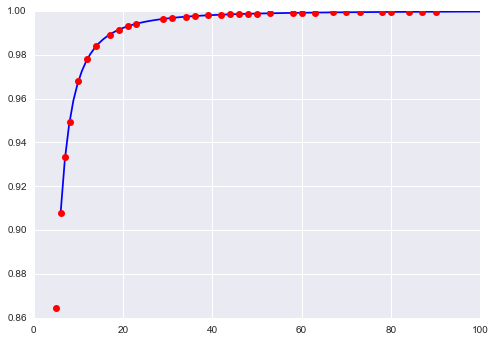

In [11]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

radius_method = "inscribed"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
]

if len(dfs) > 1:
    dfsm = dfs.groupby("measurement_resolution").mean().reset_index()

    x = list(dfsm["measurement_resolution"])
    y = list(dfsm["sphere_radius_volume_estimation_numeric"] / dfsm["sphere_radius_volume_estimation"])

    # x.append(100)
    # y.append(1.0)

    x.append(200)
    y.append(1.0)

    x = np.asarray(x)
    y = np.asarray(y)
    spl1 = InterpolatedUnivariateSpline(x, y)
    # spl1 = UnivariateSpline(x, y,k=5)
    # spl1.set_smoothing_factor(0.1)
    xs = np.linspace(6, 100, 100)

    plt.plot(
        xs[:], spl1(xs[:]), "b" , 
        x[:-2], y[:-2], "ro", 
    )
    stx = "x_cvse = ["
    for i in x:
        stx = stx + str(i) + ", "
    stx += "]"
    sty = "y_cvse = ["
    for i in y:
        sty = sty + str(i) + ", "
    sty += "]"
    print stx
    print sty


In [12]:
dfs

,appearance noise_preview,appearance show_aposteriori_surface,appearance skip_volume_generation,area volume [mm^3],areasampling areasize_mm,areasampling areasize_px,areasampling voxelsize_mm,count [],datetime,filepattern,...,sphere_numeric_surface,sphere_surface,sphere_radius_volume_estimation_numeric,sphere_radius_volume_estimation,sphere_radius_surface_estimation_numeric,sphere_radius_surface_estimation,join_surface_error,sphere_join_numeric_surface,sphere_radius_join_surface_estimation_numeric,sphere_radius_join_surface_estimation
0,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4061.656738,5026.548246,17.289101,20.0,17.978219,20.0,-964.891508,4544.102492,19.015998,20.0
5,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4061.655959,5026.548246,17.289099,20.0,17.978218,20.0,-964.892287,4544.102102,19.015997,20.0
10,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4061.656472,5026.548246,17.289100,20.0,17.978219,20.0,-964.891773,4544.102359,19.015998,20.0
15,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4061.656283,5026.548246,17.289100,20.0,17.978218,20.0,-964.891962,4544.102265,19.015998,20.0
20,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4061.655872,5026.548246,17.289099,20.0,17.978218,20.0,-964.892373,4544.102059,19.015997,20.0
25,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4359.387376,5026.548246,18.155221,20.0,18.625494,20.0,-667.160870,4692.967811,19.324971,20.0
30,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4359.387332,5026.548246,18.155221,20.0,18.625494,20.0,-667.160914,4692.967789,19.324971,20.0
35,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4359.388131,5026.548246,18.155222,20.0,18.625496,20.0,-667.160115,4692.968188,19.324972,20.0
40,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4359.387910,5026.548246,18.155222,20.0,18.625495,20.0,-667.160335,4692.968078,19.324972,20.0
45,False,True,True,1100000.0,"[110.0, 100.0, 100.0]","[110, 100, 100]","[1.0, 1.0, 1.0]",1.0,"[datetime.datetime(2017, 7, 5, 17, 54, 42, 266...",~/teigen_data/{seriesn:03d}/data{:06d}.jpg,...,4359.387346,5026.548246,18.155221,20.0,18.625494,20.0,-667.160899,4692.967796,19.324971,20.0


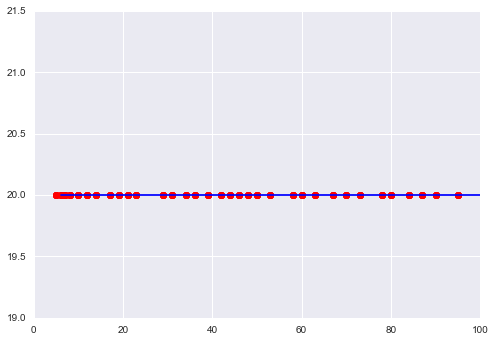

In [13]:
import scipy
import copy
if len(dfs) > 1:
    # f = scipy.interpolate.interp1d(x,y, kind="quadratic", fill_value="extrapolate")
    x = np.asarray(list(dfs["measurement_resolution"]))
    y = np.asarray(list(dfs["sphere_radius_volume_estimation"]))

    z = np.polyfit(x,y, 2)
    f = np.poly1d(z)
    plt.plot(x, y, "ro")
    plt.plot(xs, f(xs), "b")
    plt.show()

/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/Users/mjirik/miniconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[  1.99999999e+01  -6.63908593e-11   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00]


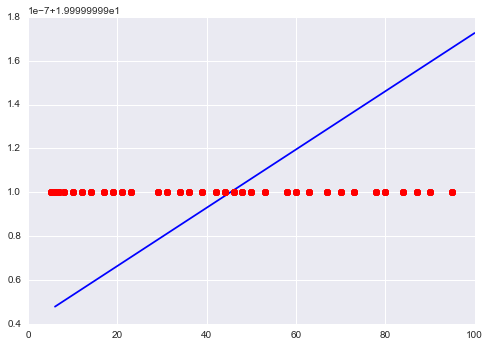

In [14]:
from scipy.optimize import curve_fit
    
def func(x, a, b, c, e, f, g):
    return a*np.exp(-b * x) # + # c + np.sin(e*x + f) * np.exp(g*x)



def func1(x, theta, omega0, K):
    jmt = (1 - theta**2)**0.5
    out = K * (1 - 1/jmt * np.exp(-1 * theta * omega0 * x))
    # out = K * (1 - (1 / jmt * np.exp(-1 * theta * omega0 * x)) * np.sin(omega0 * jmt * x)) 
    #+ np.arccos(theta))
    return out

if len(dfs) > 1:
    x = np.asarray(list(dfs["measurement_resolution"]))
    y = np.asarray(list(dfs["sphere_radius_volume_estimation"]))

    popt, pcov = curve_fit(func, x, y, bounds=(-np.inf, np.inf))
    print popt

    plt.plot(xs, func(xs, *popt), "b")
    plt.plot(x, y, "ro")
    plt.show()

## Sphere surface compensation factor interpolation

Calculate `x` and `y` coefficients for `cylinder surface + sphere compensation` and copy it into `tb_vtk.py` file in

    ...
    def polygon_radius_compensation_factos(
        ...
    ):
        ...
        x_csse = [ ... ]
        y_csse = [ ... ]



,sphere_radius_volume_estimation_numeric,sphere_radius_surface_estimation_numeric,measurement_resolution
0,17.289100,17.978218,5
1,18.155221,18.625494,6
2,18.663924,19.003892,7
3,18.987890,19.244796,8
4,19.361719,19.523073,10
5,19.561029,19.671688,12
6,19.679699,19.760288,14
7,19.784334,19.838496,17
8,19.827955,19.871126,19
9,19.859564,19.894782,21


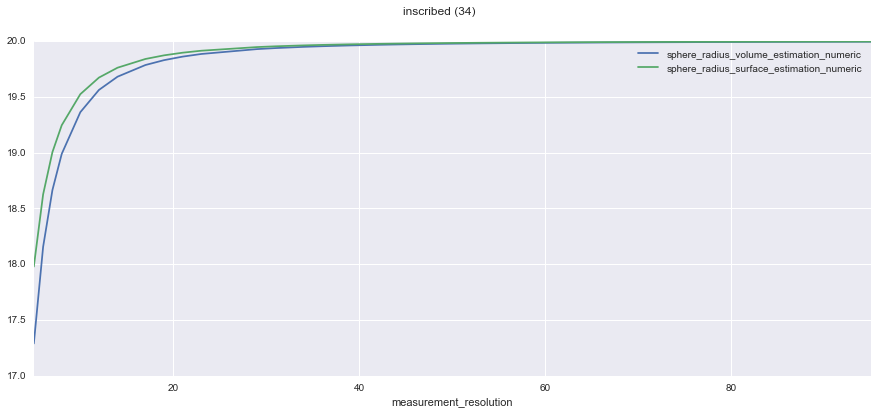

In [15]:

radius_method = "cylinder surface"
radius_method = "inscribed"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
]
dfsm = dfs.groupby("measurement_resolution").mean().reset_index()

show_radius(dfsm)


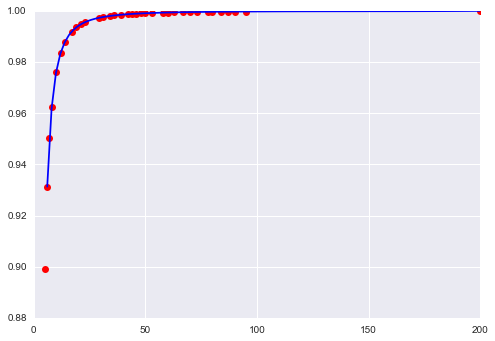

x_csse = [5, 6, 7, 8, 10, 12, 14, 17, 19, 21, 23, 29, 31, 34, 36, 39, 42, 44, 46, 48, 50, 53, 58, 60, 63, 67, 70, 73, 78, 80, 84, 87, 90, 95, 200, ]
y_csse = [0.898910918632, 0.931274723443, 0.950194578295, 0.962239811246, 0.976153670948, 0.983584378196, 0.988014411793, 0.991924785771, 0.993556301246, 0.994739096095, 0.995623800682, 0.997260361529, 0.997605276155, 0.998012238947, 0.998228507342, 0.998492277871, 0.998701247359, 0.998817315734, 0.998918487886, 0.999007210034, 0.999085459703, 0.999186550556, 0.999321349616, 0.999366042071, 0.999425223485, 0.999492061445, 0.999534825661, 0.999572408455, 0.999625645831, 0.999644190807, 0.999677378202, 0.999699309004, 0.99971907481, 0.999747949314, 1.0, ]


In [16]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
if len(dfsm) > 0:
    x = list(dfsm["measurement_resolution"])
    y = list(dfsm["sphere_radius_surface_estimation_numeric"] / dfsm["sphere_radius_surface_estimation"])

    # x.append(100)
    # y.append(1.0)

    x.append(200)
    y.append(1.0)

    x = np.asarray(x)
    y = np.asarray(y)
    spl1 = InterpolatedUnivariateSpline(x, y)
    # spl1.set_smoothing_factor(0.1)
    xs = np.linspace(6, 200, 100)

    plt.figure()
    plt.plot(x[:], y[:], "ro")
    plt.plot(xs[:], spl1(xs[:]), "b")
    plt.show()
    stx = "x_csse = ["
    for i in x:
        stx = stx + str(i) + ", "
    stx += "]"
    sty = "y_csse = ["
    for i in y:
        sty = sty + str(i) + ", "
    sty += "]"
    print stx
    print sty

# Evaluation on the same dataset

After `x` and `y` is written in the `tb_vtk.py` and experiments are re-runned

## Evaluation on 1 sphere

inscribed : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.1960577973779531e-29) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.1960577973779531e-29) 
SpearmanrResult(correlation=nan, pvalue=nan) 
170
cylinder volume : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.1960577973779531e-29) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(statistic=2020.0, pvalue=3.2132641785428004e-16) 
SpearmanrResult(correlation=nan, pvalue=nan) 
170
cylinder surface : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.1960577973779531e-29) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.1960577973779531e-29) 
SpearmanrResult(correlation=nan, pvalue=nan) 
170
cylinder volume + sphere error : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.1960577973779531e-29) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(stat

/Users/mjirik/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mjirik/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/mjirik/miniconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/mjirik/miniconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/mjirik/miniconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


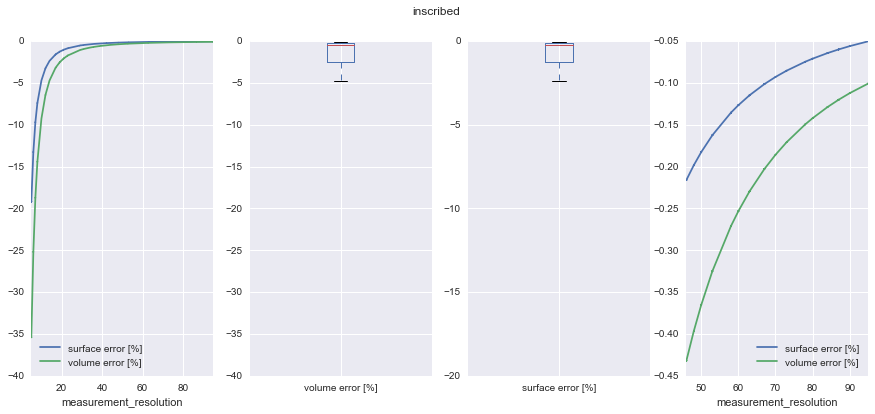

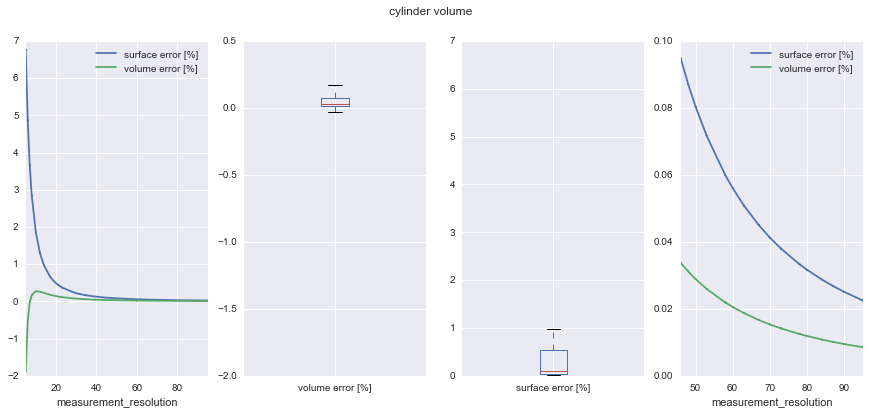

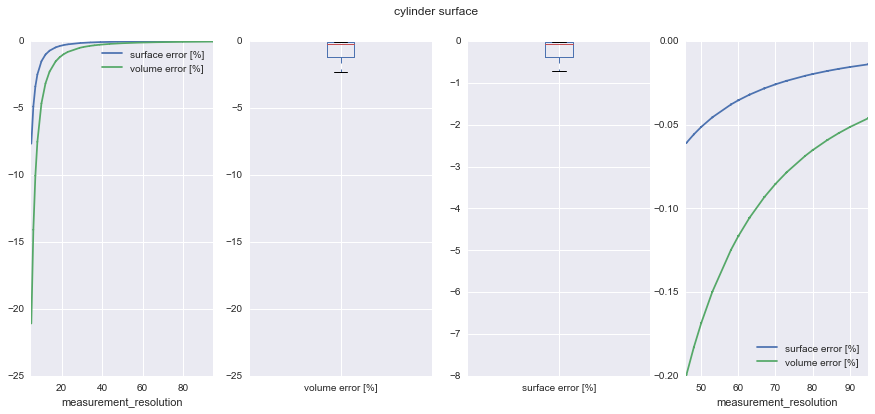

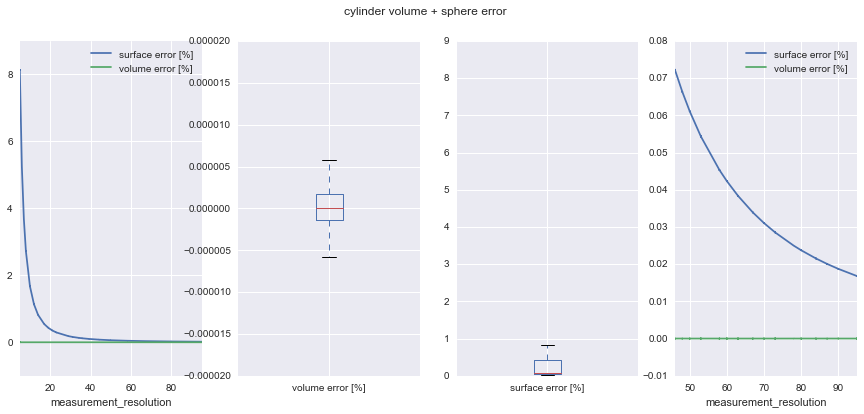

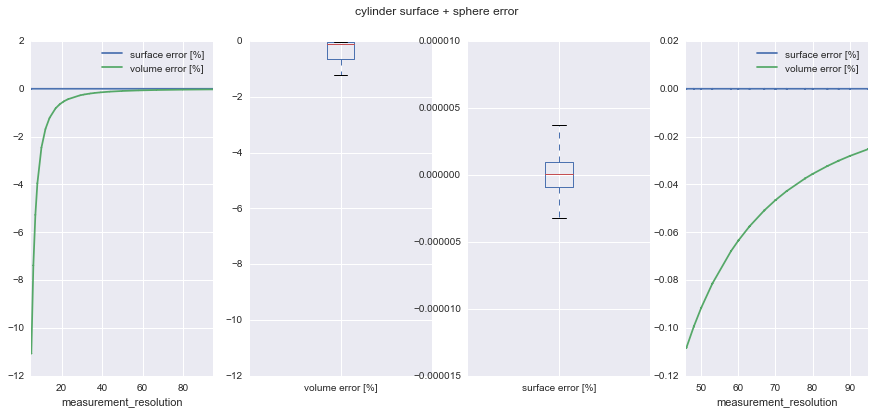

In [17]:
for radius_method in available_radius_methods:
        
    dfs = df[
        df["output note"] == "compensation method 1 sphere " + radius_method
    ]
    dfsp = show_error(dfs)



# Tube - sphere join compensation

komenzace artefaktů vzniklých na spoji koule a válce


experiment `compensation method measurement 1 tube ` 

## 1 tube - surface


x_csseje = [5, 7, 9, 11, 13, 15, 19, 23, 25, 27, 29, 33, 35, 37, 41, 43, 45, 51, 55, 57, 61, 65, 67, 69, 73, 77, 81, 85, 87, 91, 95, 100, 200, ]
y_csseje = [1.00280461843, 1.0008915901, 1.0003335719, 1.00019869299, 1.00011629061, 1.00007253692, 1.00003596271, 1.00003716463, 1.00002536491, 1.00002053443, 1.00001996422, 1.00002226941, 1.00002018493, 1.00001772083, 1.00001419362, 1.00001265241, 1.00001143422, 1.00000843313, 1.0000074585, 1.00000670063, 1.00000585268, 1.00006477878, 1.00006803908, 1.00007184803, 1.00006644751, 1.0000630609, 1.00005628084, 1.00005190342, 1.000078226, 1.000076743, 1.00007293944, 1.0, 1.0, ]


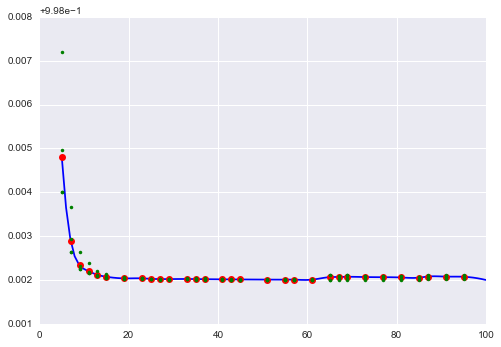

In [18]:

#  surface
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

radius_method = "cylinder surface + sphere error"

dfs = df[
    # df["output note"] == "compensation method 1 tube" + radius_method
    df["output note"] == "compensation method measurement 1 tube " + radius_method
]
if len(dfs) > 0:
    dfsm = dfs.groupby("measurement_resolution").mean().reset_index()

    # x = list(dfsm["measurement_resolution"])
    # y = list(dfsm["radius_volume_estimation_numeric"] / dfsm["radius_volume_estimation"])
    x = list(dfsm["measurement_resolution"])
    # y = list(dfsm["radius_surface_estimation_numeric"] / dfsm["radius_surface_estimation"])
    y = list(dfsm["sphere_radius_join_surface_estimation_numeric"] / dfsm["sphere_radius_join_surface_estimation"])
    # y = list(dfsm["sphere_radius_join_surface_estimation_numeric"] / dfsm["radius_distribution_mean"])
    
    x.append(100)
    y.append(1.0)

    x.append(200)
    y.append(1.0)

    x = np.asarray(x)
    y = np.asarray(y)
    spl1 = InterpolatedUnivariateSpline(x, y)
    # spl1 = UnivariateSpline(x, y,k=6)
    # spl1.set_smoothing_factor(10.01)
    xs = np.linspace(5, 100, 100)

    plt.plot(
        xs[:], spl1(xs[:]), "b" , 
        x[:-2], y[:-2], "ro", 
        list(dfs["measurement_resolution"])[:], 
        list(dfs["sphere_radius_join_surface_estimation_numeric"]/dfs["sphere_radius_join_surface_estimation"])[:],
        "g."
    )
    stx = "x_csseje = ["
    for i in x:
        stx = stx + str(i) + ", "
    stx += "]"
    sty = "y_csseje = ["
    for i in y:
        sty = sty + str(i) + ", "
    sty += "]"
    print stx
    print sty


cylinder surface + sphere error : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
124


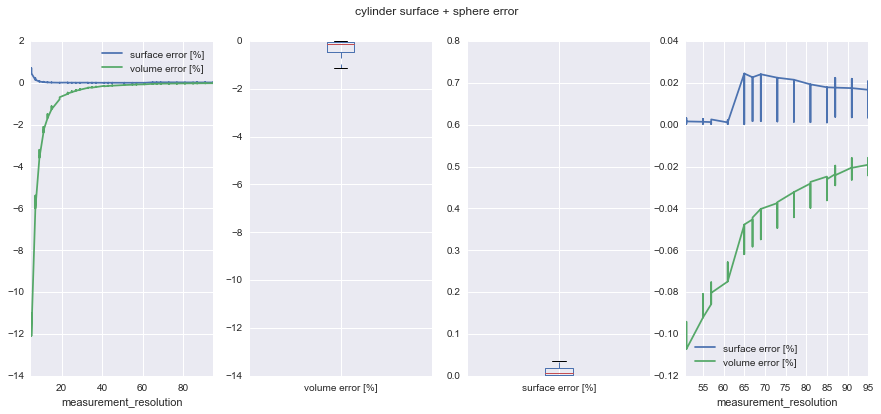

In [19]:
dfsp = show_error(dfs)

In [20]:
with pd.option_context('display.max_columns', None):
    display(dfsm)
    
    display(dfsm[["measurement_resolution", "radius_distribution_mean", 
                  "surface [mm^2]", "numeric surface [mm^2]",
                  "cylinder_surface", "sphere_surface",
                  "surface error [mm^2]", "surface error [%]", 
                  "volume [mm^3]", "numeric volume [mm^3]", 
                  "cylinder_volume",  "sphere_volume",
                  "volume error [mm^3]", "volume error [%]", 
                 ]])

,measurement_resolution,appearance noise_preview,appearance show_aposteriori_surface,appearance skip_volume_generation,area volume [mm^3],count [],generator_id,generators Continuous tubes element_number,generators Continuous tubes fixed_radius_distribution,generators Continuous tubes normal_radius_distribution,generators Continuous tubes radius_distribution_maximum,generators Continuous tubes radius_distribution_mean,generators Continuous tubes radius_distribution_minimum,generators Continuous tubes radius_distribution_standard_deviation,generators Continuous tubes random_generator_seed,generators Continuous tubes uniform_radius_distribution,generators Gensei n_objects,generators Unconnected tubes allow_overlap,generators Unconnected tubes element_number,generators Unconnected tubes fixed_radius_distribution,generators Unconnected tubes last_element_can_be_smaller,generators Unconnected tubes length_distribution_mean,generators Unconnected tubes length_distribution_standard_deviation,generators Unconnected tubes maximum_1000_iteration_number,generators Unconnected tubes normal_radius_distribution,generators Unconnected tubes orientation_alpha_rad,generators Unconnected tubes orientation_anisotropic,generators Unconnected tubes orientation_beta_rad,generators Unconnected tubes orientation_variance_rad,generators Unconnected tubes radius_distribution_maximum,generators Unconnected tubes radius_distribution_mean,generators Unconnected tubes radius_distribution_minimum,generators Unconnected tubes radius_distribution_standard_deviation,generators Unconnected tubes random_generator_seed,generators Unconnected tubes tube_shape,generators Unconnected tubes uniform_radius_distribution,generators Unconnected tubes volume_fraction,generators Voronoi tubes element_number,generators Voronoi tubes fixed_radius_distribution,generators Voronoi tubes normal_radius_distribution,generators Voronoi tubes radius_distribution_maximum,generators Voronoi tubes radius_distribution_mean,generators Voronoi tubes radius_distribution_minimum,generators Voronoi tubes radius_distribution_standard_deviation,generators Voronoi tubes random_generator_seed,generators Voronoi tubes uniform_radius_distribution,length [mm],length d. [mm^-2],measurement tube_shape,numeric surface [mm^2],numeric volume [mm^3],output aposteriori_measurement,output aposteriori_measurement_multiplier,postprocessing add_noise,postprocessing gaussian_blur,postprocessing gaussian_filter_sigma_mm,postprocessing limit_negative_intensities,postprocessing measurement_resolution,postprocessing negative,postprocessing noise_amplitude,postprocessing noise_exponent,postprocessing noise_lambda_start,postprocessing noise_lambda_stop,postprocessing noise_mean,postprocessing noise_rng_seed,surface [mm^2],surface d. [mm^-1],volume [mm^3],volume d. [],surface error [mm^2],surface error [%],volume error [mm^3],volume error [%],length_distribution_mean,radius_distribution_mean,cylinder_volume,cylinder_surface,sphere_numeric_volume,sphere_volume,sphere_numeric_surface,sphere_surface,sphere_radius_volume_estimation_numeric,sphere_radius_volume_estimation,sphere_radius_surface_estimation_numeric,sphere_radius_surface_estimation,join_surface_error,sphere_join_numeric_surface,sphere_radius_join_surface_estimation_numeric,sphere_radius_join_surface_estimation
0,5,False,True,True,1100000.0,1.0,3.0,30.0,False,False,10.0,5.0,2.0,5.0,0.0,True,10.0,False,1.0,True,False,30.0,0.0,10.0,False,0.0,False,0.0,0.1,30.0,20.0,3.0,0.0,112.5,True,False,0.1,30.0,False,False,10.0,5.0,2.0,5.0,0.0,True,20.553589,0.000019,True,7649.564390,52327.548874,False,1.0,True,True,1.0,True,5.0,False,40.0,0.0001,0.1,3.0,30.0,0.0,7609.388397,0.006918,59338.723154,0.053944,40.175992,0.545184,-7011.174280,-11.719058,30.0,20.0,37699.111843,3769.911184,14628.437031,21639.611311,3879.653205,3839.477213,16.622483,16.099761,17.290994,17.194703,40.175992,3859.565209,17.242927,17.194703
1,7,False,True,True,1100000.0,1.0,3.0,30.0,False,False,10.0,5.0,2

,measurement_resolution,radius_distribution_mean,surface [mm^2],numeric surface [mm^2],cylinder_surface,sphere_surface,surface error [mm^2],surface error [%],volume [mm^3],numeric volume [mm^3],cylinder_volume,sphere_volume,volume error [mm^3],volume error [%]
0,5,20.0,7609.388397,7649.564390,3769.911184,3839.477213,40.175992,0.545184,59338.723154,52327.548874,37699.111843,21639.611311,-7011.174280,-11.719058
1,7,20.0,7609.388397,7622.145975,3769.911184,3839.477213,12.757577,0.173119,59338.723154,55869.727535,37699.111843,21639.611311,-3468.995619,-5.791754
2,9,20.0,7609.388397,7614.161626,3769.911184,3839.477213,4.773228,0.064692,59338.723154,57273.942604,37699.111843,21639.611311,-2064.780550,-3.444578
3,11,20.0,7609.388397,7612.231515,3769.911184,3839.477213,2.843118,0.038526,59338.723154,57968.500476,37699.111843,21639.611311,-1370.222678,-2.285222
4,13,20.0,7609.388397,7611.051610,3769.911184,3839.477213,1.663212,0.022570,59338.723154,58364.430857,37699.111843,21639.611311,-974.292297,-1.624233
5,15,20.0,7609.388397,7610.425857,3769.911184,3839.477213,1.037459,0.014078,59338.723154,58609.822154,37699.111843,21639.611311,-728.901001,-1.214896
6,19,20.0,7609.388397,7609.902769,3769.911184,3839.477213,0.514371,0.006979,59338.723154,58887.056912,37699.111843,21639.611311,-451.666243,-0.752572
7,23,20.0,7609.388397,7609.971782,3769.911184,3839.477213,0.583384,0.007255,59338.723154,59033.436213,37699.111843,21639.611311,-305.286942,-0.509106
8,25,20.0,7609.388397,7609.790966,3769.911184,3839.477213,0.402569,0.004955,59338.723154,59080.120922,37699.111843,21639.611311,-258.602233,-0.431269
9,27,20.0,7609.388397,7609.716491,3769.911184,3839.477213,0.328093,0.004013,59338.723154,59117.283228,37699.111843,21639.611311,-221.439926,-0.369305


## 1 tube volume measuerement

x_cvseje = [5, 7, 9, 11, 13, 15, 19, 23, 25, 27, 29, 33, 35, 37, 41, 43, 45, 51, 55, 57, 61, 65, 67, 69, 73, 77, 81, 85, 87, 91, 95, 200, ]
y_cvseje = [1.00016060109, 1.00000045991, 0.999781214117, 1.00002153432, 0.999984546002, 0.999986251724, 1.00000199896, 0.999989169617, 0.999974198814, 0.999985921625, 0.9999951955, 0.999998502971, 1.00000178949, 1.00000359342, 0.999999259851, 0.999998648343, 0.999997430649, 1.00000576793, 1.00000262582, 1.00000426568, 1.00000121655, 1.0000049034, 1.00000506061, 1.00000511941, 1.00000306134, 1.00000425606, 1.00000622994, 1.00000603282, 1.00000472439, 1.00000393567, 1.00000214441, 1.0, ]


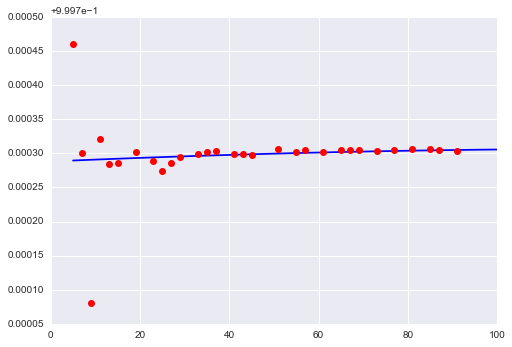

In [21]:

# volume 
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

radius_method = "cylinder volume + sphere error"
# radius_method = "cylinder surface + sphere error"

dfs = df[
    df["output note"] == "compensation method measurement 1 tube " + radius_method
]
if len(dfs) > 0:
    dfsm = dfs.groupby("measurement_resolution").mean().reset_index()

    x = list(dfsm["measurement_resolution"])
    y = list(dfsm["sphere_radius_volume_estimation_numeric"] / dfsm["sphere_radius_volume_estimation"])

    # x.append(100)
    # y.append(1.0)

    x.append(200)
    y.append(1.0)

    x = np.asarray(x)
    y = np.asarray(y)
    # spl1 = InterpolatedUnivariateSpline(x, y)
    spl1 = UnivariateSpline(x, y,k=2)
    spl1.set_smoothing_factor(0.1)
    xs = np.linspace(5, 100, 100)

    plt.plot(
        xs[:], spl1(xs[:]), "b" , 
        x[:-2], y[:-2], "ro", 
    )
    stx = "x_cvseje = ["
    for i in x:
        stx = stx + str(i) + ", "
    stx += "]"
    sty = "y_cvseje = ["
    for i in y:
        sty = sty + str(i) + ", "
    sty += "]"
    print stx
    print sty


cylinder volume + sphere error : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
volume (w/s): 
WilcoxonResult(statistic=2978.0, pvalue=0.02529760034594947) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
124


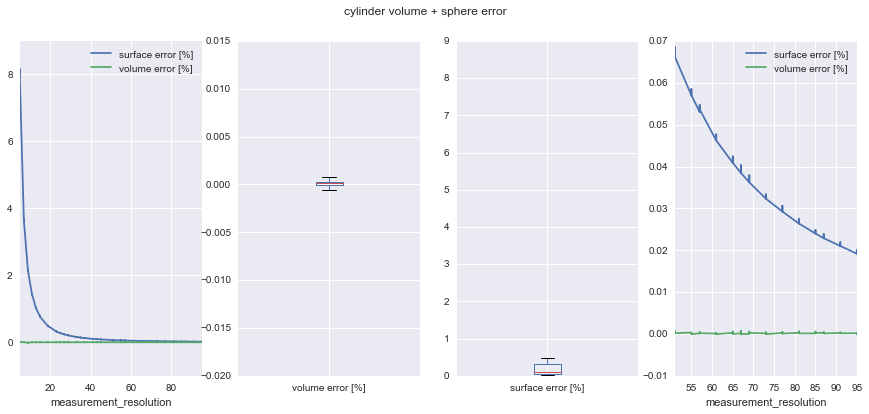

In [22]:
dfsp = show_error(dfs)

inscribed : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.8950104635447409, pvalue=1.3470753964099371e-44) 
124
cylinder volume + sphere error : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
volume (w/s): 
WilcoxonResult(statistic=2978.0, pvalue=0.02529760034594947) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
124
cylinder surface + sphere error : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488411835, pvalue=5.1029191736438855e-51) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=4.3301098959311251e-22) 
SpearmanrResult(correlation=0.91858852488

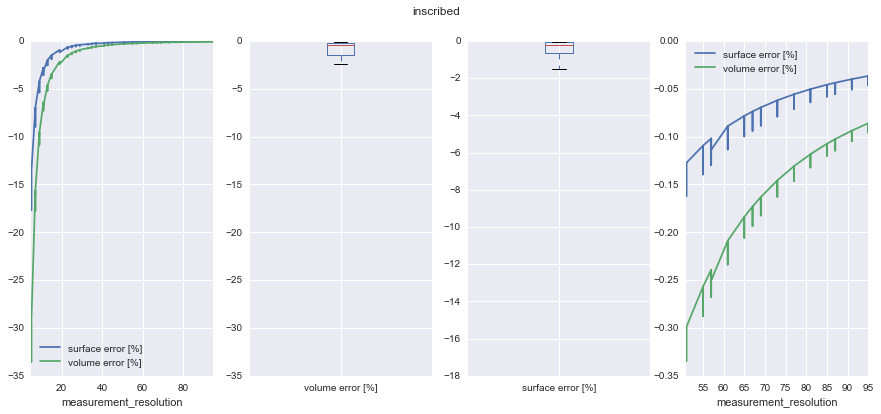

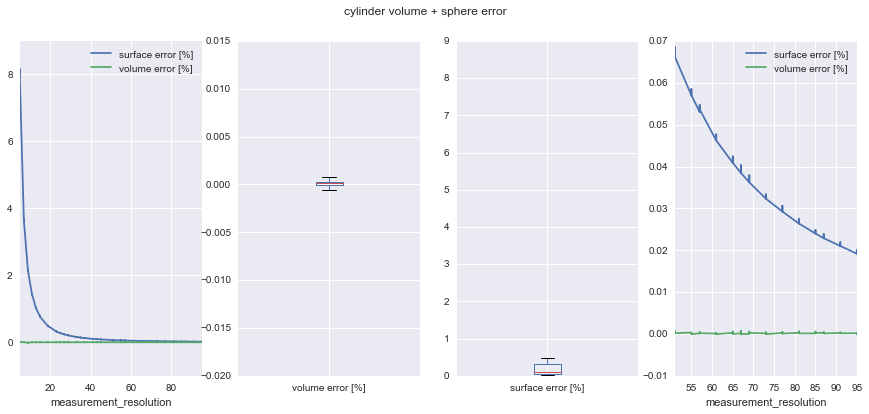

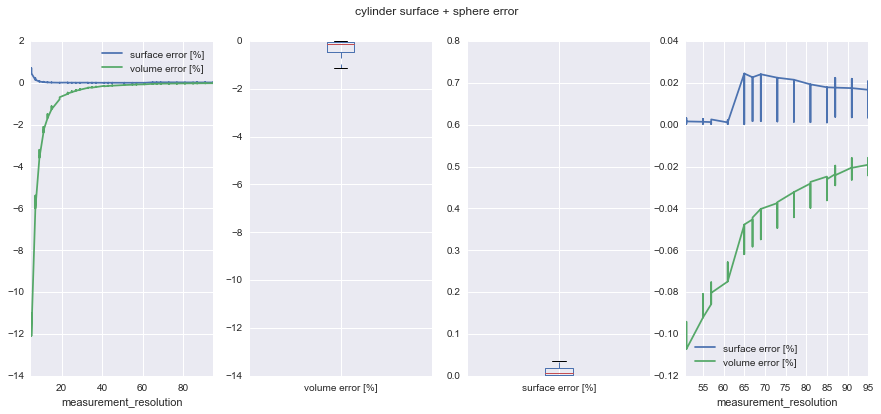

In [23]:
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "compensation method measurement 1 tube " + radius_method
    ]
    dfsp = show_error(dfs)



In [24]:
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "compensation method 1 tube " + radius_method
    ]
    dfsp = show_error(dfs)



## TODO - move this - 3 spheres various radius

In [25]:
run_label = "compensation method 3 spheres various radius "
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == run_label + radius_method
    ]
    dfsp = show_error(dfs, x_key="radius_distribution_mean")



## tubes

### 1 Tube evaluation

In [26]:
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "compensation method 1 tube " + radius_method
    ]
    dfsp = show_error(dfs) #, x_key="radius_distribution_mean")

### 1 tube various radius

In [27]:
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "compensation method 1 tube various radius " + radius_method
    ]
    dfsp = show_error(dfs, x_key="radius_distribution_mean")
    print len(dfs)



0
0
0
0
0
0
0
0
0


In [28]:
run_label = "compensation method 1 tube various length "
for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == run_label + radius_method
    ]
    dfsp = show_error(dfs, x_key="length_distribution_mean")
    # print len(dfs)



In [29]:
for radius_method in available_radius_methods:
        
    dfs = df[
        df["output note"] == "compensation method 1 tube mix " + radius_method
    ]
    dfsp = show_error(dfs)



### 5 tubes

In [30]:
for radius_method in available_radius_methods:
        
    dfs = df[
        df["output note"] == "compensation method 5 tubes " + radius_method
    ]
    dfsp = show_error(dfs)



## Fixed resolution

In [31]:

for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "fixed resolution " + radius_method
    ]
    dfsp = show_error(dfs)



# Best test

In [32]:

for radius_method in available_radius_methods:
    dfs = df[
        df["output note"] == "best test " + radius_method
    ]
    dfsp = show_error(dfs)



# Simple check - this computes selected radius from data

/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


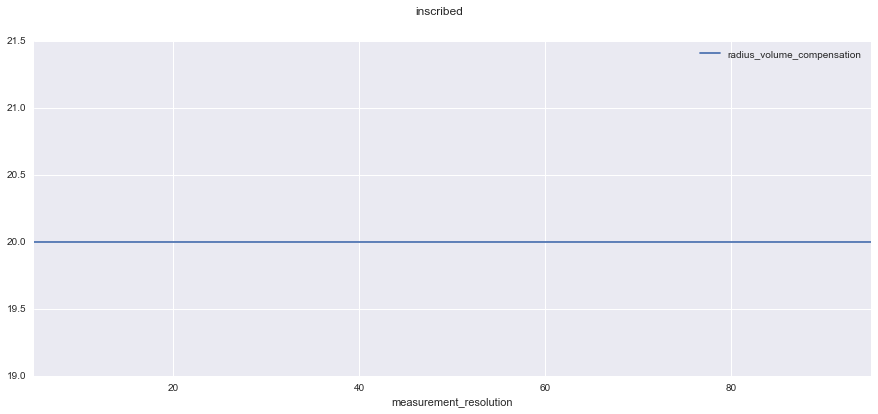

In [33]:
# just for control - this should be exactly same as selected radius
radius_method = "inscribed"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
    # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
]

if len(dfs) > 1:
    dfs["radius_volume_compensation"] = (3 * dfs["volume [mm^3]"] / (4* np.pi))**(1.0/3.0)
    dfsp = dfs[["radius_volume_compensation", "measurement_resolution"]].sort_values(
        "measurement_resolution")

    fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(111)
    dfsp.plot(
        ax=ax, x="measurement_resolution", **plotkw)
    plt.suptitle(radius_method)